In [1]:
# Get code and images


import matplotlib.pyplot as plt
import numpy as np

im = plt.imread('../data/example_image/ISIC_0001769.jpg')
mask=plt.imread('../data/example_segmentation/ISIC_0001769_segmentation.png')


# Measure some things in the mask




3.545708406819518


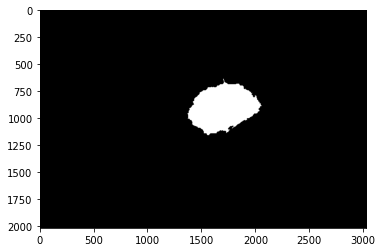

In [2]:

#Total size of the image
total = mask.shape[0] * mask.shape[1] 

#Size of mask only
area = np.sum(mask)

#As percentage
print(area/total*100)

plt.imshow(mask, cmap='gray')


In [4]:
# A way to measure height or width of the mask

#How many 1's in each column of the image (sum over axis 0, i.e. rows)
pixels_in_col = np.sum(mask, axis=0)
print(pixels_in_col)
print(pixels_in_col.shape)

max_pixels_in_col = np.max(pixels_in_col)
print('height is', max_pixels_in_col)

# pixels_in_row = 


[0. 0. 0. ... 0. 0. 0.]
(3024,)
height is 469.0


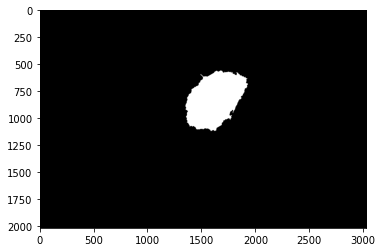

In [6]:
# How to measure diameter at an angle - transform the image first, then measure

from skimage import transform

rot_im = transform.rotate(mask, 30)
plt.imshow(rot_im, cmap='gray')


# Find perimeter using morphology

In [7]:
from skimage import morphology

#Structural element, that we will use as a "brush" on our mask. The parameter is "brush size"
struct_el = morphology.disk(2)

print(struct_el)

[[0 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 0 0]]


216160.0
212178


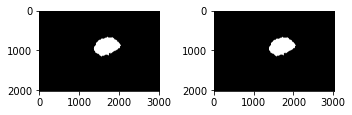

In [8]:
# Use this "brush" to erode the image - eat away at the borders

mask_eroded = morphology.binary_erosion(mask, struct_el)

# Show side by side (depending on brush size, you might not see a difference visually)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(mask, cmap='gray')
axes[1].imshow(mask_eroded, cmap='gray')
fig.tight_layout()

# Verify the new mask is smaller
new_area= np.sum(mask_eroded)

print(area)
print(new_area)


3982.0


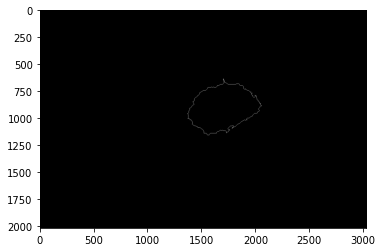

In [9]:
# Subtract the two masks from each other to get the border/perimeter

image_perimeter = mask - mask_eroded

plt.imshow(image_perimeter, cmap='gray') #Depending on the size of the "brush" it might be difficult to see on the screen

#What is the length of this perimeter = how many 1s? 
print(np.sum(image_perimeter))


# Creating your own mask

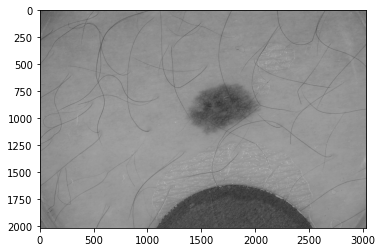

In [26]:
# Work with color image as grayscale

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray = rgb2gray(im)
plt.imshow(gray, cmap='gray')



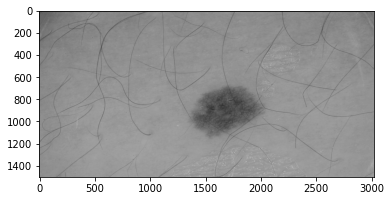

In [11]:
# Let's get rid of the marker
gray2 = gray[0:1500,:]
plt.imshow(gray2, cmap='gray')

mask2 = mask[0:1500,:]


KeyboardInterrupt: 

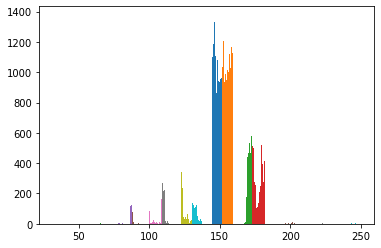

In [12]:
#Look at intensities of image
plt.hist(gray2)


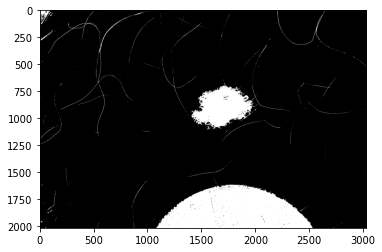

In [28]:
# Threshold
mymask = gray < 120  #Pixels with lower intensities will be equal to 1 in the mask
plt.imshow(mymask, cmap='gray')

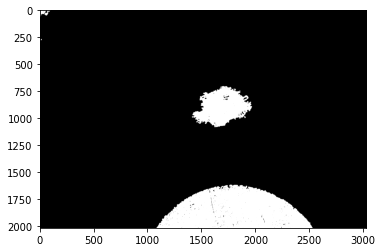

In [30]:
# There is some noise at the borders of the lesion, and some hair
# We can get rid of it by morphological operators

from skimage.morphology import opening

# Opening = first EROSION, then DILATION 

# Erosion will get rid of hairs but also make the lesion smaller. 
# Dilation will restore the lesion (but not the hairs)

struct_el = morphology.disk(5)
opened = opening(mymask, struct_el)

plt.imshow(opened, cmap='gray')

# OK got rid of some noise, but te border is still not as smooth as we think it should be

## More morphology

You might be interested in other functions provided in this package, see https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html 

# Filtering

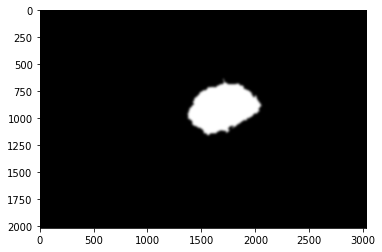

In [16]:
# Gaussian filtering (blur)

from skimage import filters

blurred = filters.gaussian(mask,sigma=10) #Sigma is the "brush size" - how far away from each pixel will the blurring take into account

plt.imshow(blurred, cmap='gray')

#What kind of values are in the image now?



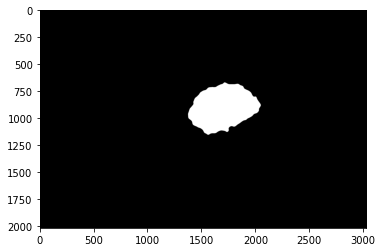

In [17]:
# Threshold the blurred mask

mask2 = blurred > 0.5
plt.imshow(mask2, cmap='gray')


/usr/local/lib/python3.9/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


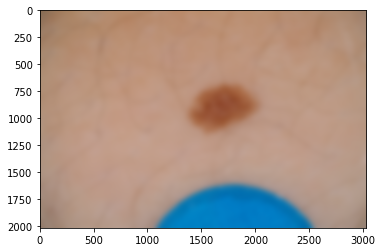

In [18]:
# You can also blur color images - this could be useful for measuring color (variability)

blurred = filters.gaussian(im,sigma=25)

plt.imshow(blurred)


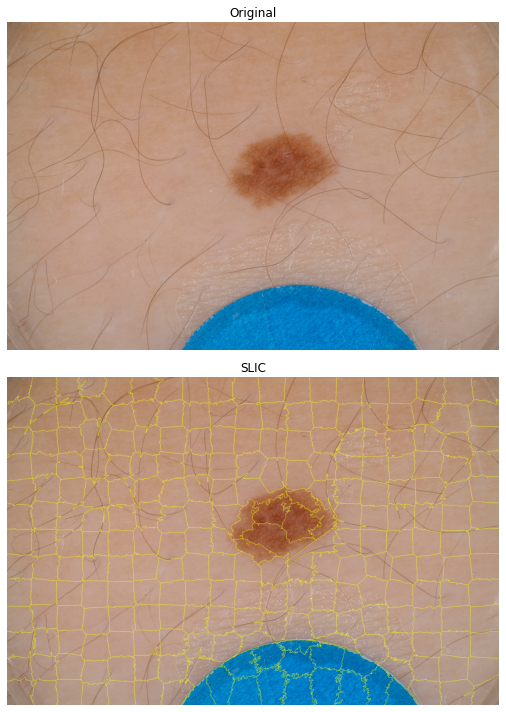

In [19]:
# SLIC clustering - see also https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html

from skimage.segmentation import slic, mark_boundaries

# Divide the pixels into segments (segment = piece of continuous color in the image)
segments_slic = slic(im, n_segments=250, compactness=10, sigma=1, start_label=1)

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=True)

ax[0].imshow(im)
ax[0].set_title("Original")
ax[1].imshow(mark_boundaries(im, segments_slic))
ax[1].set_title('SLIC')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()




# General purpose features

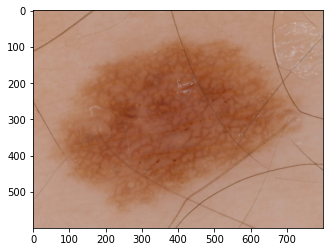

In [20]:
# Many examples in https://scikit-image.org/docs/dev/api/skimage.feature.html 

# Let's crop the image first 

im2 = im[600:1200,1300:2100,:]
mask2 = mask[600:1200,1300:2100]
plt.imshow(im2)

# How can you get these coordinates automatically from the mask?




In [21]:
# skimage has some general purpose feature implementations in more recent versions, you might need to update
!pip install scikit-image==0.18.0


# Example in microscopy: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_trainable_segmentation.html#sphx-glr-auto-examples-segmentation-plot-trainable-segmentation-py 


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 4.6 MB/s eta 0:00:0000:0100:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [22]:
from skimage import feature #for feature extraction

#Extract feature images
feat_im = feature.multiscale_basic_features(im2, multichannel=True, intensity=False, edges=False, texture=True, sigma_min = 2, sigma_max = 8)
print(feat_im.shape)


/tmp/ipykernel_23229/687379060.py:4: FutureWarning: `multichannel` is a deprecated argument name for `multiscale_basic_features`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feat_im = feature.multiscale_basic_features(im2, multichannel=True, intensity=False, edges=False, texture=True, sigma_min = 2, sigma_max = 8)


(600, 800, 18)


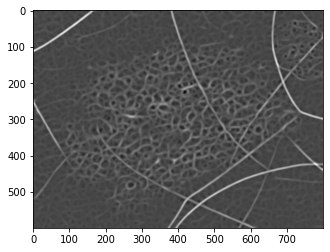

In [23]:
# What does this look like?
feature_index = 2
plt.imshow(feat_im[:,:,feature_index], cmap='gray')


[    19     65   2122  32986 311409  84260  28117   8629   4216   2983
   2119   1459    924    392    254     46]


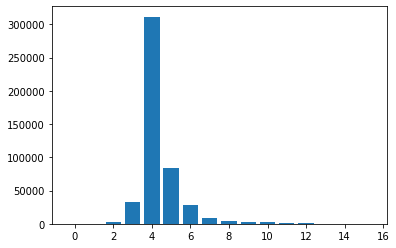

In [24]:
# We measured some features for every pixel in the image - but for classification, we need features per IMAGE

# For classification we need to combine the outputs for each feature type into one vector

feature_index = 2
feat_vec, bin_edges = np.histogram(feat_im[:,:,feature_index], bins=16)

plt.bar(np.arange(0,16), feat_vec)
print(feat_vec)

# Now this feature image is summarized by 16 numbers 

In [25]:
# Many pixels fall into the same bin because we just split all intensities into 16 groups
# We can adjust the bins, so the distribution of pixels is more equal 

feature_index=0

# Make flat versions of the image and mask (easier to manipulate)
flat_im = np.ndarray.flatten(feat_im[:,:,feature_index])
flat_mask = np.ndarray.flatten(mask2)

# Look ONLY pixels inside the mask
flat_im = flat_im[flat_mask==1]

# Find quantiles of the pixel values (25% of the values goes into teh same bin)
quantile_bins = np.quantile(flat_im, np.arange(0,1,0.25))

# These bins have different widths
print(quantile_bins)
print('{:f}, {:f}, {:f}, {:f}'.format(quantile_bins[0], quantile_bins[1], quantile_bins[2], quantile_bins[3]))



[-5.92534384e-03  7.37850132e-06  5.24795149e-04  1.17999743e-03]
-0.005925, 0.000007, 0.000525, 0.001180


In [ ]:
# Note that bins should be the same across images (for a particular feature). 

# Define bins once on "representative image" (how?), then use for all images